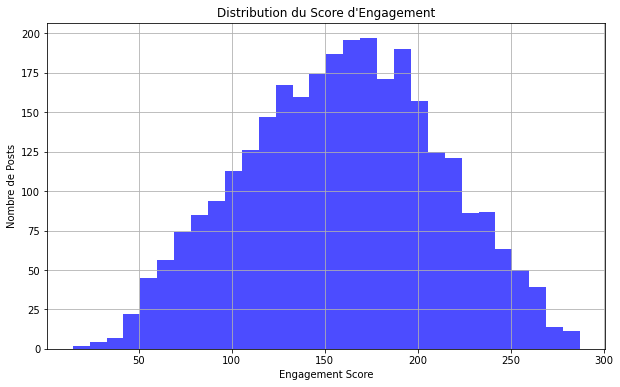

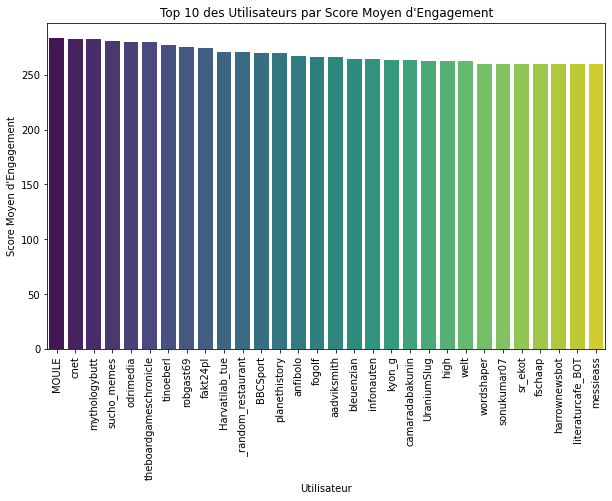

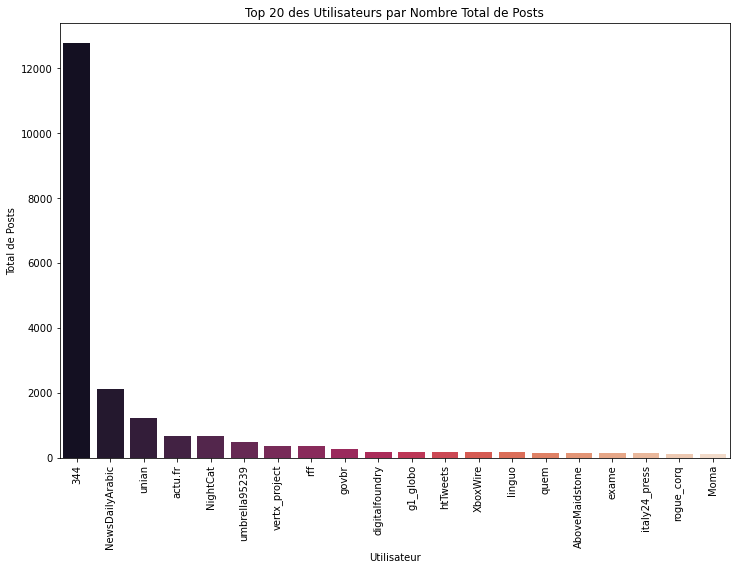

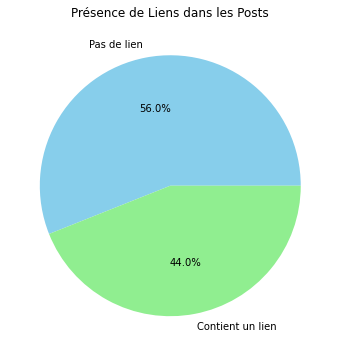

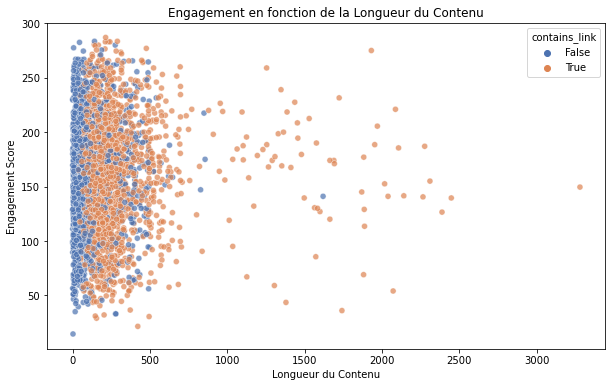

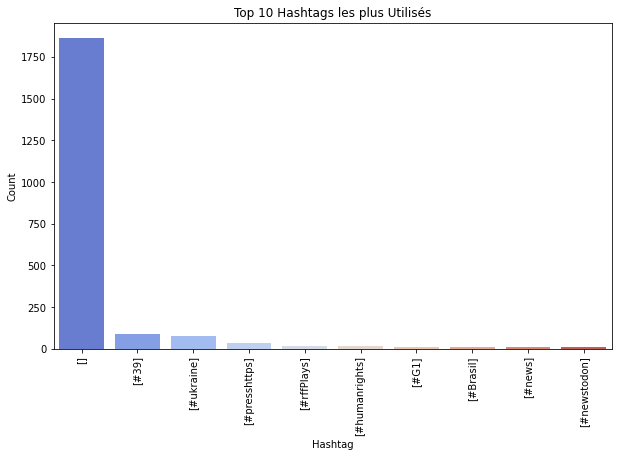

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

# 1. Créer une session Spark
spark = SparkSession.builder \
    .appName("PostgresToSpark") \
    .config("spark.jars", "/usr/local/spark/jars/postgresql-42.3.9.jar") \
    .getOrCreate()

# 2. Configurer les paramètres de connexion
jdbc_url = "jdbc:postgresql://postgres:5432/DB_Mastodon"
properties = {
    "user": "fadi",       
    "password": "fadi",   
    "driver": "org.postgresql.Driver"  
}

# 3. Lire les données depuis PostgreSQL
df_gold = spark.read.jdbc(url=jdbc_url, table="Mostodon_GOLD_bis", properties=properties)
df_gold = df_gold.toPandas()  # Convertir le dataframe Spark en pandas

# Visualisation 1: Distribution du score d'engagement
plt.figure(figsize=(10, 6))
plt.hist(df_gold['engagement_score'], bins=30, color='blue', alpha=0.7)
plt.title('Distribution du Score d\'Engagement')
plt.xlabel('Engagement Score')
plt.ylabel('Nombre de Posts')
plt.grid(True)
plt.show()

# Visualisation 2: Engagement moyen par utilisateur
# Calculer la moyenne de l'engagement par utilisateur
df_grouped = df_gold.groupby('username')['avg_engagement_score'].mean().reset_index()

# Trier par ordre décroissant pour obtenir les utilisateurs avec le score moyen le plus élevé
df_grouped_top10 = df_grouped.sort_values(by='avg_engagement_score', ascending=False).head(30)

# Visualiser le top 10 des utilisateurs par score moyen d'engagement
plt.figure(figsize=(10, 6))
sns.barplot(x='username', y='avg_engagement_score', data=df_grouped_top10, palette="viridis")

# Ajouter les titres et les labels
plt.title('Top 10 des Utilisateurs par Score Moyen d\'Engagement')
plt.xlabel('Utilisateur')
plt.ylabel('Score Moyen d\'Engagement')
plt.xticks(rotation=90)
plt.show()


# Calculer le nombre total de posts par utilisateur
df_posts = df_gold.groupby('username')['total_posts'].sum().reset_index()

# Trier par ordre décroissant pour obtenir les utilisateurs avec le plus grand nombre de posts
df_posts_top20 = df_posts.sort_values(by='total_posts', ascending=False).head(20)

# Visualiser le top 20 des utilisateurs par nombre total de posts
plt.figure(figsize=(12, 8))
sns.barplot(x='username', y='total_posts', data=df_posts_top20, palette="rocket")

# Ajouter les titres et les labels
plt.title('Top 20 des Utilisateurs par Nombre Total de Posts')
plt.xlabel('Utilisateur')
plt.ylabel('Total de Posts')
plt.xticks(rotation=90)
plt.show()


# Visualisation 4: Présence de liens dans les posts
contains_link_counts = df_gold['contains_link'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(contains_link_counts, labels=['Pas de lien', 'Contient un lien'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Présence de Liens dans les Posts')
plt.show()

# Visualisation 5: Engagement en fonction de la longueur du contenu
plt.figure(figsize=(10, 6))
sns.scatterplot(x='content_length', y='engagement_score', data=df_gold, hue='contains_link', palette="deep", alpha=0.7)
plt.title('Engagement en fonction de la Longueur du Contenu')
plt.xlabel('Longueur du Contenu')
plt.ylabel('Engagement Score')
plt.show()

# Visualisation 6: Popularité des hashtags
from collections import Counter

# Compter la fréquence des hashtags
tags_flat = [tag for sublist in df_gold['tags'].dropna() for tag in sublist.split(',')]
tags_count = pd.DataFrame(Counter(tags_flat).most_common(), columns=['Hashtag', 'Count'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Hashtag', y='Count', data=tags_count.head(10), palette="coolwarm")
plt.title('Top 10 Hashtags les plus Utilisés')
plt.xticks(rotation=90)
plt.show()

# Fermer la session Spark
spark.stop()
